In [61]:
# ----------------------------------------------------------------------------
#
# TITLE - linear_model_prior.ipynb
# AUTHOR - James Lane
# PROJECT - AST 1501
#
# ----------------------------------------------------------------------------
#
# Docstrings and metadata:
'''Determine the best-fitting linear model with the addition of a prior. Compare to 
data from other sources
'''

__author__ = "James Lane"

In [62]:
# General
import numpy as np
import pdb, sys, importlib, copy, importlib
from tqdm import tqdm_notebook

## Plotting
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import animation
from matplotlib import colors
from matplotlib import cm

## Astropy
from astropy import units as apu
from astropy.io import fits
from astropy.table import Table

## Scipy
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.optimize import curve_fit
from scipy import linalg
import scipy as sc

## Galpy
from galpy import potential

## Add project-specific package. Assume relative location
sys.path.append('../../src/')
import ast1501.util
import ast1501.fourier
import ast1501.df
import ast1501.linear_model

In [63]:
### Matplotlib for notebooks
%config InlineBackend.figure_format = 'retina'

In [64]:
importlib.reload(ast1501.linear_model)

<module 'ast1501.linear_model' from '../../src/ast1501/linear_model.py'>

# Meta

## Information:

## Future Work:

Test the new ```LinearModel``` class

# Prepare

## Load Data

In [141]:
### Load catalogs
gaiadr2_apogee_catalog = '../../data/generated/gaiadr2-apogee_dataset.FIT'
f = fits.open(gaiadr2_apogee_catalog)
data = f[1].data

### Cut on galactocentric absolute Z < 0.3 kpc
where_low_z = np.where( np.abs(data['Z']) < 0.3 )[0]
data_low_z = data[where_low_z] 
z_select_text = r'$|$Z$_{GC}| < 0.3$ kpc'

### Read catalog values

# ID, RA, Dec, logg, abundances, errors
apid = data_low_z['APOGEE_ID']
locid = data_low_z['LOCATION_ID']
vhelio = data_low_z['VHELIO']
pmll = data_low_z['PM_LL']
pmbb = data_low_z['PM_BB']
gc_x = data_low_z['X']
gc_y = data_low_z['Y']
gc_z = data_low_z['Z']
gc_vx = data_low_z['VX']
gc_vy = data_low_z['VY']
gc_vz = data_low_z['VZ']

### Convert to galactocentric radius and radial velocity
gc_R = np.sqrt(np.square(gc_x)+np.square(gc_y))
gc_phi = np.arctan2(gc_y,gc_x)
gc_vR = np.cos(gc_phi)*gc_vx + np.sin(gc_phi)*gc_vy
gc_vT = np.sin(gc_phi)*gc_vx - np.cos(gc_phi)*gc_vy
gc_phi = np.arctan2(gc_y,-gc_x)

## Set Parameters

In [204]:
# Radial bin range and size
R_lim = [12,15]
R_bin_size = 1.0
R_bin_cents = np.arange( R_lim[0], R_lim[1], R_bin_size ) + R_bin_size/2

# Phi bin range and size
phi_lim = [-np.pi/2, np.pi/2]
phi_bin_size = np.pi/30
phi_bin_cents = np.arange( phi_lim[0], phi_lim[1], phi_bin_size ) + phi_bin_size/2

# Phib bin range and size
phib_lim = [0, np.pi/2]
phib_bin_size = np.pi/30
phib_bin_cents = np.arange( phib_lim[0], phib_lim[1], phib_bin_size ) + phi_bin_size/2


## Try and initialize the class

### Load using Gaia data

In [274]:
importlib.reload(ast1501.linear_model)

<module 'ast1501.linear_model' from '../../src/ast1501/linear_model.py'>

In [275]:
lm1 = ast1501.linear_model.LinearModel(instantiate_method=1, gc_R=gc_R, 
    gc_phi=gc_phi, gc_vR=gc_vR, gc_vT=gc_vT, R_lims=R_lim, 
    R_bin_size=R_bin_size, phi_lims=phi_lim, 
    phi_bin_size=phi_bin_size, phib_lims=phib_lim, n_bs=100,
    phib_bin_size=phib_bin_size, force_yint_zero_vR=False)


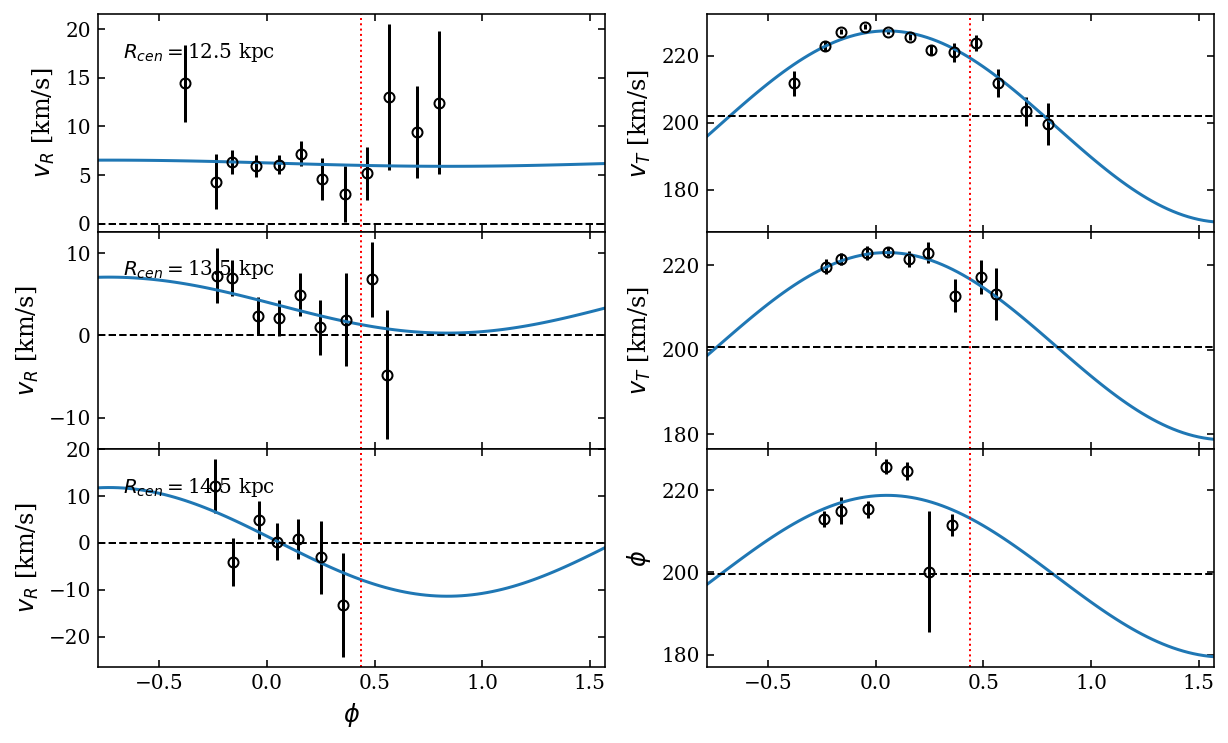

In [276]:
fig, axs = lm1.plot_vRvT_known_m_b_phi(phi_lim=[-np.pi/4,np.pi/2])
plt.show()
plt.close('all')

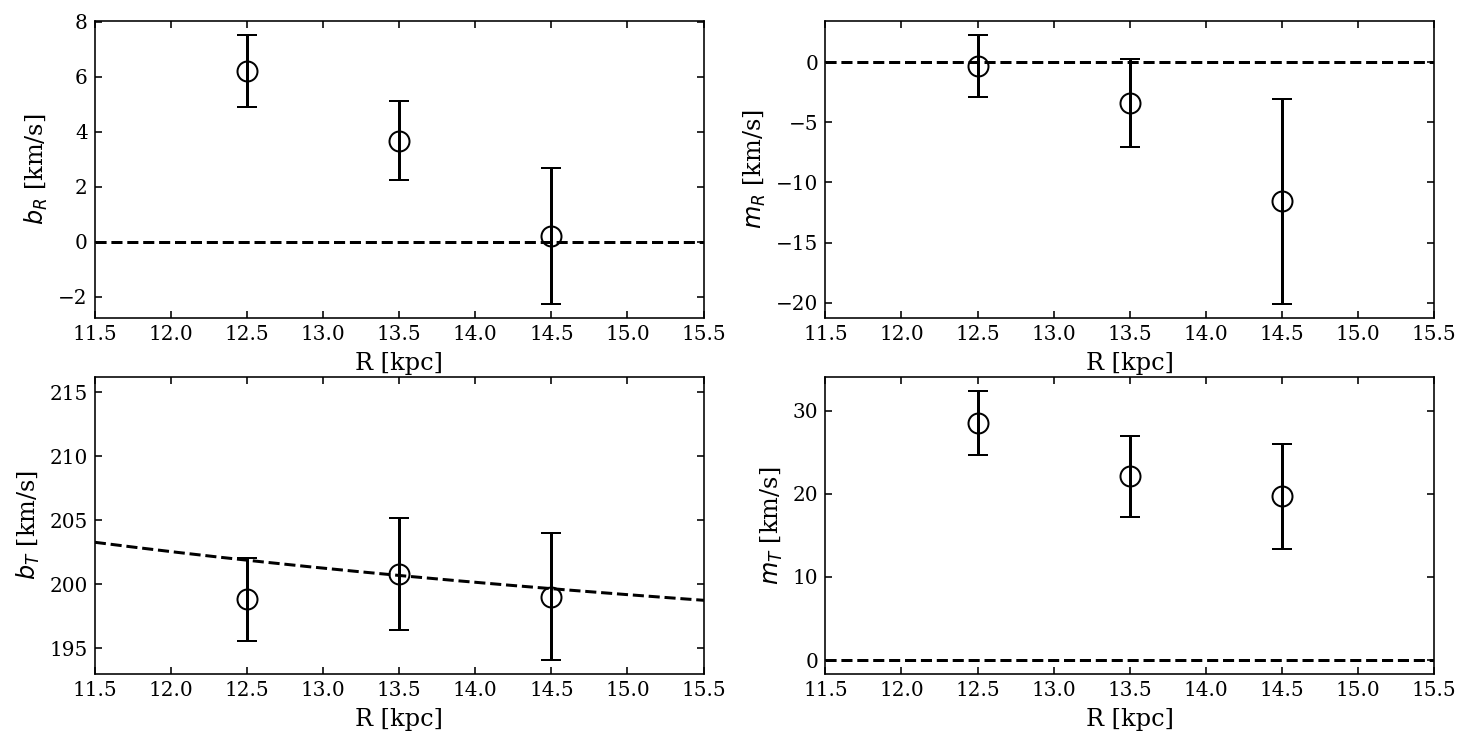

In [277]:
plot_kws={'ecolor':'Black','marker':'o','markeredgecolor':'Black','color':'Black','markersize':10,
          'markerfacecolor':'None','capsize':5,'fmt':'o'}
fig, axs = lm1.plot_m_r(plot_kws=plot_kws)
plt.show()
plt.close('all')

### Load using DF velocity field filename

In [115]:
importlib.reload(ast1501.linear_model)

<module 'ast1501.linear_model' from '../../src/ast1501/linear_model.py'>

In [116]:
lm2 = ast1501.linear_model.LinearModel(instantiate_method=2, 
    df_filename='../../scripts/generate_spiral_df/base/data.npy', phib_bin_size=phib_bin_size,
    phib_lims=phib_lim)

../../src/ast1501/linear_model.py:1501: RuntimeWarning: divide by zero encountered in log
  extra_variance=extra_variance[j,0] )

../../src/ast1501/linear_model.py:1507: RuntimeWarning: divide by zero encountered in log
  force_yint_zero=self.force_yint_zero_vR)



In [129]:
lm2_bs_sample_vR = lm2.bs_sample_vR
lm2_bs_sample_vT = lm2.bs_sample_vT

### Load using pre-calculated bs_samples

In [132]:
lm3 = ast1501.linear_model.LinearModel(instantiate_method=3,
    bs_sample_vT=lm2_bs_sample_vT, bs_sample_vR=lm2_bs_sample_vR, phib_lims=phib_lim, 
    phib_bin_size=phib_bin_size)

../../src/ast1501/linear_model.py:1501: RuntimeWarning: divide by zero encountered in log
  likelihood_vT[j,:] = np.log(lin_likelihood_vT)

../../src/ast1501/linear_model.py:1507: RuntimeWarning: divide by zero encountered in log
  likelihood_vR[j,:] = np.log(lin_likelihood_vR)



In [139]:
lm3.b_vR

array([-3.55271368e-15,  0.00000000e+00, -4.44089210e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  8.88178420e-16,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00])